In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import sys
sys.path.append('../')
from brain2brain import utils
from brain2brain import generators
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
# Read saved paths for training.
saved_paths_676 = utils.get_file_paths("../brain2brain/train_676_norm_files.txt")

In [4]:
# Split the train files into a training and validation set.
train_676, test_676 = utils.split_file_paths(saved_paths_676, 0.8)

In [5]:
# Print the number of samples.
print(utils.get_total_sample_count(train_676, lookback=512 * 5, length = 1, delay = 512 * 0))

16455


In [6]:
electrode_count = np.load(train_676[0]).shape[1]

In [7]:
print(electrode_count)

114


In [8]:
# Test Generator.
test_generator = generators.FGenerator(file_paths = train_676, lookback=512 * 5, length = 1, delay = 512 * 0,
                                       batch_size = 32, sample_period = 512 / 64, electrodes= np.arange(0, 114),
                                       shuffle = True)

In [9]:
len(test_generator)

514

In [10]:
X, y = test_generator[0]

In [11]:
X.shape

(32, 320, 114)

In [12]:
y.shape

(32, 1, 114)

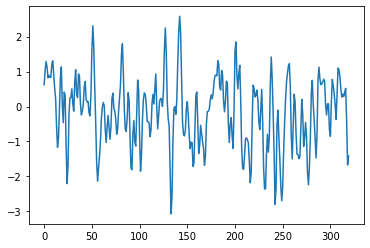

In [13]:
# Plot one electrode
plt.plot(range(X.shape[1]), X[0,:,113])

In [14]:
# Computing the common-sense baseline MAE
def evaluate_naive_method(generator):
    start_time = time.time()
    electrode_maes = np.zeros(electrode_count)
    electrode_n = np.zeros(electrode_count)
    batch_count = len(generator)
    for ix in range(batch_count):

        samples, targets = generator[ix]
        
        forecasts = samples[:, -1, :]
        # For each sample and electrode calculate the difference
        # between forecasted value and actual value.
        maes = np.abs(forecasts - targets[:, 0, :])

        # For each electrode (column, axis=0),
        # calculate the mean of the difference.
        maes = np.sum(maes, axis=0)
        electrode_maes += maes
        electrode_n += np.ones(electrode_count)
    print(f"Elapsed time: {time.time() - start_time}")
    return electrode_maes / electrode_n
electrode_maes = evaluate_naive_method(test_generator)
print(electrode_maes)

Elapsed time: 487.71277356147766
[13.97766667 13.36350816 13.15501537 14.37242513 14.50404457 10.96948043
 14.1173386  11.99533459 12.76271485 14.25533822 14.03547503 15.0208996
 14.73366677 13.77674186 13.18777901 12.91988808 13.84907004 14.12730581
 15.31904999 14.78741928 13.30168558 14.67055307 14.5051339  13.96777848
 13.47015873 13.68410026 14.89698239 14.72155646 15.35834476 14.39574246
 14.47911075 13.89118796 11.90857118 12.75715317 14.78419602 13.22148636
 13.42286288 13.87884652 14.08075717 14.46564279 11.40962756 14.35371689
 14.59139794 14.56164714 12.89032336 13.53320507 14.31116042 13.25354743
 11.01852317 14.25142714 14.39825004 14.7893437  14.85438541 14.31631039
 14.25105181 12.08197975 10.3010074  14.02574678 14.57184579 14.45279485
 14.13635634 14.22008485 14.35858867 14.29349214  9.2878312  10.24406153
 10.79498678 13.54947154 11.47287117 11.39525165 12.21913466 14.21612601
 14.18666908 15.12893147 14.9429453  14.70234744 14.44803712 13.06820824
 13.46110652 13.658

### Granger's Causality Test
Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.


In [17]:
# Read raw data and perform tests.
file_path = train_676[0]
np_arr = np.load(file_path)
# np_arr.shape
file0_df = pd.DataFrame(data=np_arr[0:,0:],    # values
                        index=np.arange(0, len(np_arr)),
                        columns=np.arange(0, len(np_arr[0])))
print(file0_df.shape)  # (123, 8)
file0_df.tail()

(49689, 114)


,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
49684,0.302958,0.341664,0.846095,0.251356,1.306208,0.159971,2.862887,0.037572,-0.826404,1.096719,...,0.761587,1.097518,0.312319,0.753257,0.292491,0.711298,1.956131,0.573206,1.092333,1.147616
49685,0.434544,0.384250,0.874808,0.359851,1.273852,0.119387,2.770416,-0.034099,-0.865936,1.002311,...,0.787126,1.128372,0.333961,0.747720,0.294806,0.777773,1.998619,0.664752,1.169933,1.210464
49686,0.555317,0.411883,0.899447,0.478983,1.238046,0.082885,2.678162,-0.088491,-0.916288,0.903448,...,0.813710,1.143427,0.356057,0.741068,0.296350,0.834072,2.018228,0.753942,1.243008,1.268169
49687,0.660855,0.423038,0.919008,0.605381,1.198177,0.050636,2.590161,-0.124890,-0.977932,0.803567,...,0.840543,1.142530,0.380061,0.733487,0.298944,0.879134,2.015583,0.840072,1.308569,1.318872
49688,0.747075,0.416732,0.932709,0.735557,1.153607,0.022458,2.510141,-0.143541,-1.050312,0.706166,...,0.866722,1.125688,0.407296,0.725163,0.304361,0.912462,1.991914,0.922700,1.364214,1.361072


In [18]:
# DF with 12 electrodes, 2 minutes
file0_df = file0_df.iloc[:512*120,0:12]

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for e1 in df.columns:
        print(e1)
        for e2 in df.columns:
            test_result = grangercausalitytests(data[[e2, e1]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {e2}, X = {e1}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[e2, e1] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df
causation_matrix_df = grangers_causation_matrix(file0_df, variables = file0_df.columns)        

0
1
2
3
4
5
6
7
8
9
10
11


In [20]:
causation_matrix_df

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x
0_y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_y,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2_y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3_y,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5_y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6_y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
#     print(out.cvt)
    def adjust(val, length=6):
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(trace)
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        
result_cointegration = cointegration_test(file0_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
181465.3284636038
0      ::  181465.33 > 311.1288  =>   True
160479.15635593073
1      ::  160479.16 > 263.2603  =>   True
140004.013315472
2      ::  140004.01 > 219.4051  =>   True
120614.86786578309
3      ::  120614.87 > 179.5199  =>   True
101890.27790594184
4      ::  101890.28 > 143.6691  =>   True
84219.16952989747
5      ::  84219.17  > 111.7797  =>   True
68572.76938834283
6      ::  68572.77  > 83.9383   =>   True
53984.04259325705
7      ::  53984.04  > 60.0627   =>   True
40506.85355782296
8      ::  40506.85  > 40.1749   =>   True
27518.288955592787
9      ::  27518.29  > 24.2761   =>   True
15271.624574754227
10     ::  15271.62  > 12.3212   =>   True
5404.103293453112
11     ::  5404.1    > 4.1296    =>   True


In [24]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [25]:
# ADF Test on each column
for name, column in file0_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.2239
 No. Lags Chosen       = 57
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.3198
 No. Lags Chosen       = 57
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [27]:
nobs = 12
df_train, df_test = file0_df[0:-nobs], file0_df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(49677, 12)
(12, 12)


In [28]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -63.81415979366357
BIC :  -63.786483023333865
FPE :  1.9313568950369242e-28
HQIC:  -63.80548756317459 

Lag Order = 2
AIC :  -112.94717564275732
BIC :  -112.89395013454946
FPE :  8.864716931227163e-50
HQIC:  -112.9304979631889 

Lag Order = 3
AIC :  -159.70550240246894
BIC :  -159.62672724444369
FPE :  4.3730211565793295e-70
HQIC:  -159.6808189730894 

Lag Order = 4
AIC :  -201.79073357547244
BIC :  -201.686407855639
FPE :  2.3088616611261336e-88
HQIC:  -201.75804409553268 

Lag Order = 5
AIC :  -232.27669429860245
BIC :  -232.1468171049185
FPE :  1.3289645545562496e-101
HQIC:  -232.2359984673359 

Lag Order = 6
AIC :  -232.4957589860983
BIC :  -232.34032940646998
FPE :  1.0675170433871351e-101
HQIC:  -232.44705650272098 

Lag Order = 7
AIC :  -233.4630981718223
BIC :  -233.2821152941041
FPE :  4.057558157604736e-102
HQIC:  -233.4063887355327 

Lag Order = 8
AIC :  -236.06073011898332
BIC :  -235.85419303097822
FPE :  3.0208387330097266e-103
HQIC:  -235.99601342896

In [29]:
order_results = model.select_order(12)

In [30]:
order_results.summary()

,AIC,BIC,FPE,HQIC
0,-1.699,-1.697,0.1828,-1.699
1,-63.81,-63.79,1.931e-28,-63.81
2,-112.9,-112.9,8.858e-50,-112.9
3,-159.7,-159.6,4.374e-70,-159.7
4,-201.8,-201.7,2.309e-88,-201.8
5,-232.3,-232.1,1.327e-101,-232.2
6,-232.5,-232.3,1.066e-101,-232.4
7,-233.5,-233.3,4.053e-102,-233.4
8,-236.1,-235.9,3.017e-103,-236.0
9,-237.0,-236.8,1.143e-103,-237.0


In [31]:
model_fitted = model.fit(12)
# model_fitted.summary()

In [32]:
def adjust(val, length=6):
        return str(val).ljust(length)

In [33]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 4))

0      : 2.132
1      : 2.1392
2      : 2.1292
3      : 2.129
4      : 2.1302
5      : 2.132
6      : 2.1315
7      : 2.135
8      : 2.1356
9      : 2.1374
10     : 2.131
11     : 2.1354


In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = file0_df[-lag_order:]
forecast_input

12


,0,1,2,3,4,5,6,7,8,9,10,11
49677,-0.561804,-0.200413,0.620120,-0.008845,1.462348,0.442438,3.190910,0.791210,-0.669036,1.411592,0.561891,-0.424037
49678,-0.470935,-0.110890,0.649929,-0.033526,1.447618,0.417862,3.199619,0.683070,-0.697982,1.414453,0.436327,-0.378977
49679,-0.363728,-0.022549,0.681081,-0.037398,1.429924,0.383608,3.186286,0.568170,-0.720357,1.400450,0.324713,-0.322608
49680,-0.243024,0.063211,0.713626,-0.019813,1.409716,0.342464,3.152263,0.450691,-0.738499,1.369427,0.228889,-0.255542
49681,-0.112139,0.144613,0.747206,0.019102,1.387256,0.297186,3.099733,0.334919,-0.755199,1.321938,0.150091,-0.178654
49682,0.025226,0.219631,0.781137,0.078462,1.362609,0.250312,3.031592,0.225018,-0.773473,1.259265,0.088920,-0.093054
49683,0.165032,0.286074,0.814471,0.156637,1.335668,0.204001,2.951339,0.124803,-0.796303,1.183361,0.045392,-0.000060
49684,0.302958,0.341664,0.846095,0.251356,1.306208,0.159971,2.862887,0.037572,-0.826404,1.096719,0.019064,0.098905
49685,0.434544,0.384250,0.874808,0.359851,1.273852,0.119387,2.770416,-0.034099,-0.865936,1.002311,0.009040,0.202258
49686,0.555317,0.411883,0.899447,0.478983,1.238046,0.082885,2.678162,-0.088491,-0.916288,0.903448,0.014052,0.308303


In [35]:
fc = model_fitted.forecast(y=forecast_input.to_numpy(), steps = 12)
df_forecast = pd.DataFrame(fc)
df_forecast

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.810374,0.392620,0.940063,0.866064,1.103704,-0.002090,2.441312,-0.145627,-1.131836,0.614602,0.102301,0.625242
1,0.847792,0.351092,0.940924,0.993614,1.047911,-0.023572,2.386205,-0.133188,-1.219948,0.531930,0.149456,0.724661
2,0.857196,0.293296,0.935495,1.115169,0.985829,-0.042542,2.346574,-0.108960,-1.311269,0.460795,0.201857,0.818159
3,0.837420,0.221119,0.924316,1.228017,0.917278,-0.059428,2.323320,-0.076155,-1.401817,0.403305,0.257289,0.904196
4,0.788359,0.137124,0.908208,1.329848,0.842335,-0.074465,2.316470,-0.038248,-1.487262,0.360954,0.313595,0.981366
5,0.711018,0.044434,0.888220,1.418789,0.761371,-0.087641,2.325196,0.001262,-1.563211,0.334572,0.368726,1.048436
6,0.607492,-0.053417,0.865547,1.493422,0.675088,-0.098680,2.347872,0.039073,-1.625511,0.324297,0.420802,1.104396
7,0.480921,-0.152655,0.841438,1.552778,0.584509,-0.107069,2.382193,0.072303,-1.670518,0.329616,0.468157,1.148478
8,0.335363,-0.249471,0.817108,1.596334,0.490955,-0.112116,2.425316,0.098652,-1.695344,0.349403,0.509385,1.180180
9,0.175616,-0.340215,0.793658,1.623981,0.396000,-0.113032,2.474019,0.116517,-1.698037,0.382001,0.543371,1.199293


In [36]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_forecast.columns
    for col in columns:  
        print(col)
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_fc[col]
    return df_fc

In [37]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['0_forecast', '1_forecast', '2_forecast', '3_forecast',
                   '4_forecast', '5_forecast', '6_forecast', '7_forecast',
                   '8_forecast', '9_forecast', '10_forecast', '11_forecast']]

0
1
2
3
4
5
6
7
8
9
10
11


,0_forecast,1_forecast,2_forecast,3_forecast,4_forecast,5_forecast,6_forecast,7_forecast,8_forecast,9_forecast,10_forecast,11_forecast
0,0.810374,0.392620,0.940063,0.866064,1.103704,-0.002090,2.441312,-0.145627,-1.131836,0.614602,0.102301,0.625242
1,0.847792,0.351092,0.940924,0.993614,1.047911,-0.023572,2.386205,-0.133188,-1.219948,0.531930,0.149456,0.724661
2,0.857196,0.293296,0.935495,1.115169,0.985829,-0.042542,2.346574,-0.108960,-1.311269,0.460795,0.201857,0.818159
3,0.837420,0.221119,0.924316,1.228017,0.917278,-0.059428,2.323320,-0.076155,-1.401817,0.403305,0.257289,0.904196
4,0.788359,0.137124,0.908208,1.329848,0.842335,-0.074465,2.316470,-0.038248,-1.487262,0.360954,0.313595,0.981366
5,0.711018,0.044434,0.888220,1.418789,0.761371,-0.087641,2.325196,0.001262,-1.563211,0.334572,0.368726,1.048436
6,0.607492,-0.053417,0.865547,1.493422,0.675088,-0.098680,2.347872,0.039073,-1.625511,0.324297,0.420802,1.104396
7,0.480921,-0.152655,0.841438,1.552778,0.584509,-0.107069,2.382193,0.072303,-1.670518,0.329616,0.468157,1.148478
8,0.335363,-0.249471,0.817108,1.596334,0.490955,-0.112116,2.425316,0.098652,-1.695344,0.349403,0.509385,1.180180
9,0.175616,-0.340215,0.793658,1.623981,0.396000,-0.113032,2.474019,0.116517,-1.698037,0.382001,0.543371,1.199293


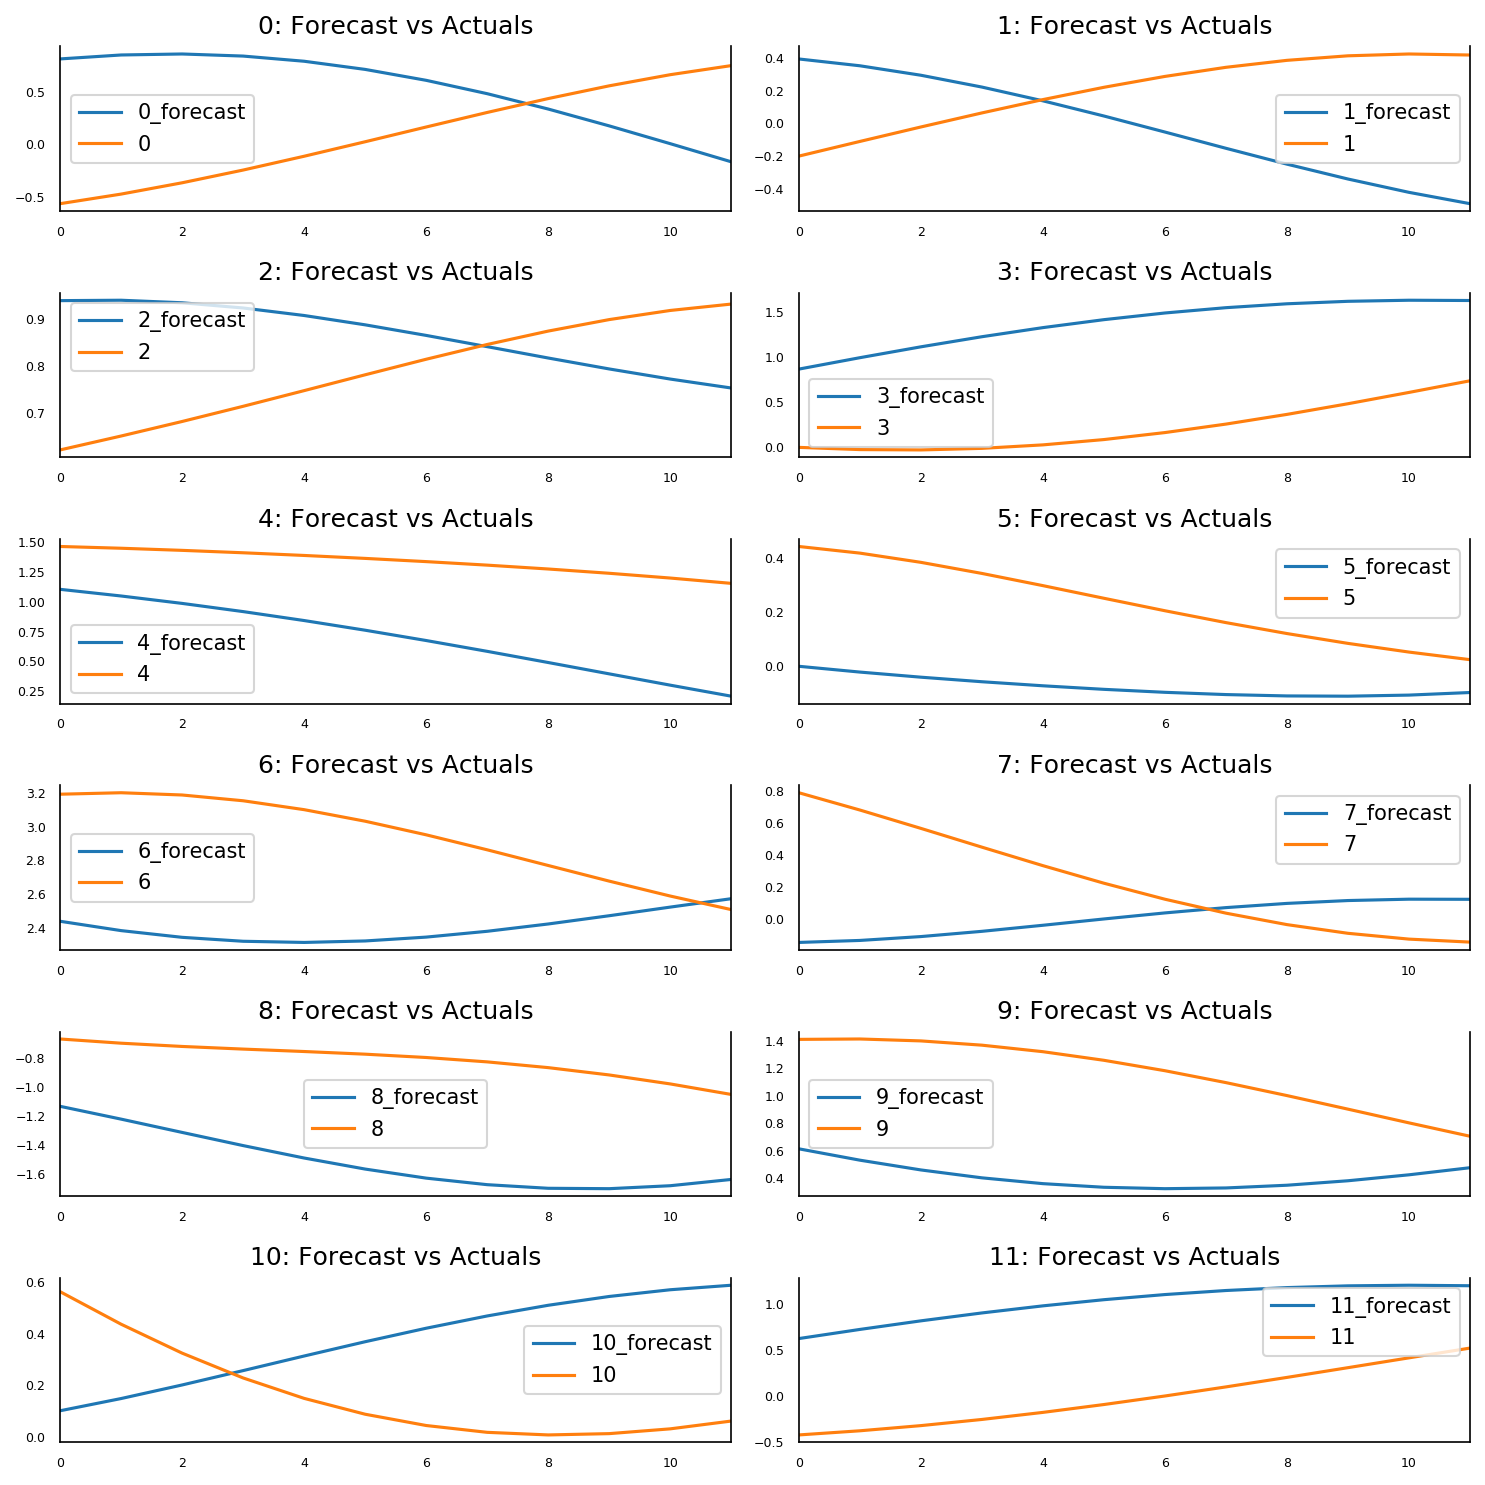

In [38]:
fig, axes = plt.subplots(nrows=int(len(file0_df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(file0_df.columns, axes.flatten())):
    df_results[str(col)+'_forecast'].plot(legend=True, ax=ax)
    plot_df_test = df_test.set_index(df_results.index)
    plot_df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(str(col) + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [40]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
mean_mae = 0
mean_mae_count = 0
for i in np.arange(0, 12):
    print(f'\nForecast Accuracy of: {i}')
    accuracy_prod = forecast_accuracy(df_results[f'{i}_forecast'].values, df_test[i])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))
        if k == "mae":
            mean_mae += v
            mean_mae_count +=1
print (mean_mae / mean_mae_count)


Forecast Accuracy of: 0
mape   :  4.5543
me     :  0.4295
mae    :  0.7703
mpe    :  0.5214
rmse   :  0.8757
corr   :  -0.9376
minmax :  1.0242

Forecast Accuracy of: 1
mape   :  2.8969
me     :  -0.2188
mae    :  0.4736
mpe    :  -2.4805
rmse   :  0.5465
corr   :  -0.9561
minmax :  1.3125

Forecast Accuracy of: 2
mape   :  0.2158
me     :  0.075
mae    :  0.1575
mpe    :  0.1255
rmse   :  0.1836
corr   :  -0.9713
minmax :  0.1707

Forecast Accuracy of: 3
mape   :  27.6261
me     :  1.1584
mae    :  1.1584
mpe    :  -9.5993
rmse   :  1.1693
corr   :  0.8089
minmax :  0.868

Forecast Accuracy of: 4
mape   :  0.4937
me     :  -0.6408
mae    :  0.6408
mpe    :  -0.4937
rmse   :  0.6685
corr   :  0.9968
minmax :  0.4937

Forecast Accuracy of: 5
mape   :  1.9151
me     :  -0.3085
mae    :  0.3085
mpe    :  -1.9151
rmse   :  0.327
corr   :  0.9155
minmax :  1.9151

Forecast Accuracy of: 6
mape   :  0.1771
me     :  -0.5296
mae    :  0.5404
mpe    :  -0.1728
rmse   :  0.6119
corr   :  -0.799